In [1]:
import pandas as pd
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

In [2]:
btc_ohlcv = pd.read_csv('Bitcoin futures (USDT) 25-03-2020-10-36-00_03-05-2025-00-00-00 timeframe 1m.csv')
btc_ohlcv.set_index('timestamp', inplace=True)
btc_ohlcv.index = pd.to_datetime(btc_ohlcv.index)
btc_ohlcv

,open,high,low,close,volume
timestamp,,,,,
2020-03-25 10:36:00,6500.0,6500.0,6500.0,6500.0,0.001
2020-03-25 10:37:00,6500.0,6500.0,6500.0,6500.0,0.000
2020-03-25 10:38:00,6500.0,6500.0,6500.0,6500.0,0.000
2020-03-25 10:39:00,6500.0,6500.0,6500.0,6500.0,0.000
2020-03-25 10:40:00,6500.0,6500.0,6500.0,6500.0,0.000
...,...,...,...,...,...
2025-05-02 23:56:00,96789.9,96796.9,96789.9,96796.9,9.169
2025-05-02 23:57:00,96796.9,96840.0,96796.9,96831.7,42.991
2025-05-02 23:58:00,96831.7,96833.5,96831.6,96833.5,11.743


In [ ]:
def sliding_max(arr: np.ndarray, k: int) -> np.ndarray:
    """Sliding-window maximum (window size k) for arr."""
    n = arr.size
    max_vals = np.full(n, np.nan)
    dq = deque()
    for i in range(n):
        # mantieni solo valori utili nel deque
        while dq and arr[i] >= arr[dq[-1]]:
            dq.pop()
        dq.append(i)
        # scarta indici fuori finestra
        if dq[0] <= i - k:
            dq.popleft()
        # a i>=k-1 ho il primo max valido
        if i >= k - 1:
            max_vals[i] = arr[dq[0]]
    return max_vals

def sliding_min(arr: np.ndarray, k: int) -> np.ndarray:
    """Sliding-window minimum (window size k) for arr."""
    n = arr.size
    min_vals = np.full(n, np.nan)
    dq = deque()
    for i in range(n):
        while dq and arr[i] <= arr[dq[-1]]:
            dq.pop()
        dq.append(i)
        if dq[0] <= i - k:
            dq.popleft()
        if i >= k - 1:
            min_vals[i] = arr[dq[0]]
    return min_vals

def extreme_return_histogram(
    df: pd.DataFrame,
    T: int,
    agg: int = 1,
    bin_width: float = 0.01
):
    """
    Restituisce:
      - hist: counts per bin
      - bin_edges: array dei bordi dei bin
      - hist_dict: dict {interval_str: count}
    Parametri:
      df: DataFrame con indice datetime e colonna 'close'
      T: look-ahead window in #candele
      agg: aggregazione (1 = minuto; es. 1440 = giornata)
      bin_width: ampiezza del bin (es. 0.01 = 1%)
    """
    # 1) aggregazione
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    close = df['close']
    if agg > 1:
        close = close.resample(f'{agg}T').last().dropna()
    close_vals = close.values
    n = close_vals.size
    if n <= T:
        raise ValueError(f"T={T} troppo grande rispetto a #candele={n}")

    # 2) log-price
    log_close = np.log(close_vals)

    # 3) sliding-window sui successivi T punti
    arr_rev = log_close[::-1]
    rev_max = sliding_max(arr_rev, T)
    rev_min = sliding_min(arr_rev, T)
    valid = n - T
    max_log = rev_max[T - 1 : n - 1][::-1]
    min_log = rev_min[T - 1 : n - 1][::-1]

    # 4) rendimenti estremi
    returns_max = np.exp(max_log - log_close[:valid]) - 1
    returns_min = np.exp(min_log - log_close[:valid]) - 1

    # 5) unisco e istogramma
    all_returns = np.concatenate([returns_min, returns_max])
    min_edge = np.floor(all_returns.min() / bin_width) * bin_width
    max_edge = np.ceil(all_returns.max() / bin_width) * bin_width
    bins = np.arange(min_edge, max_edge + bin_width, bin_width)
    hist, bin_edges = np.histogram(all_returns, bins=bins)

    # costruisco il dizionario {intervallo: count}
    hist_dict = {}
    for i in range(len(hist)):
        left = bin_edges[i] * 100
        right = bin_edges[i+1] * 100
        key = f"[{left:.1f}%, {right:.1f}%)"
        hist_dict[key] = int(hist[i])

    # plot
    plt.figure(figsize=(10, 6))
    centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.bar(centers, hist, width=bin_width, edgecolor='black')
    plt.xlabel('Rendimento')
    plt.ylabel('Frequenza')
    plt.title(
        f"Istogramma movimenti estremi entro {T*agg} candele\n"
        f"(agg={agg}, bin={bin_width*100:.1f}%)"
    )
    plt.grid()
    plt.show()

    return hist, bin_edges, hist_dict

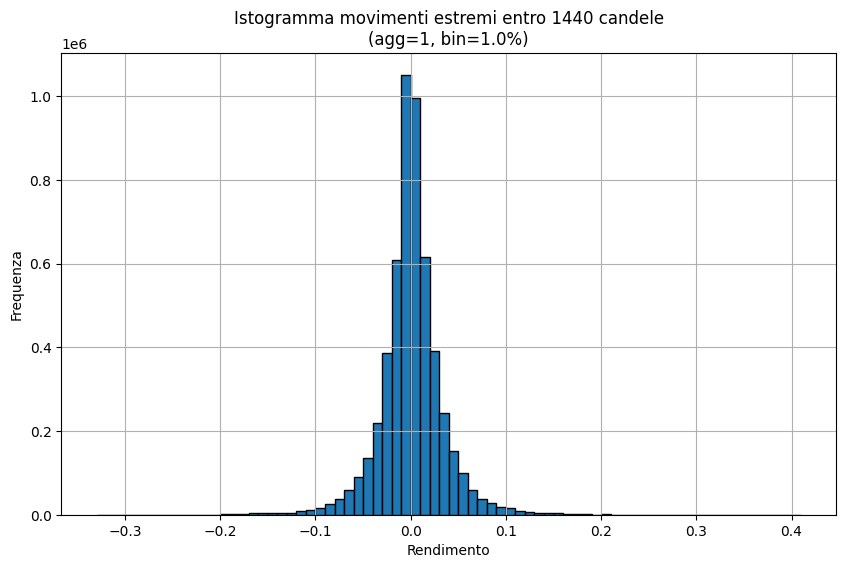

[-33.0%, -32.0%): 2
[-32.0%, -31.0%): 226
[-31.0%, -30.0%): 428
[-30.0%, -29.0%): 73
[-29.0%, -28.0%): 19
[-28.0%, -27.0%): 512
[-27.0%, -26.0%): 315
[-26.0%, -25.0%): 201
[-25.0%, -24.0%): 316
[-24.0%, -23.0%): 209
[-23.0%, -22.0%): 351
[-22.0%, -21.0%): 344
[-21.0%, -20.0%): 318
[-20.0%, -19.0%): 942
[-19.0%, -18.0%): 2890
[-18.0%, -17.0%): 2744
[-17.0%, -16.0%): 3431
[-16.0%, -15.0%): 4277
[-15.0%, -14.0%): 4882
[-14.0%, -13.0%): 4263
[-13.0%, -12.0%): 5198
[-12.0%, -11.0%): 7796
[-11.0%, -10.0%): 11508
[-10.0%, -9.0%): 15789
[-9.0%, -8.0%): 24691
[-8.0%, -7.0%): 36996
[-7.0%, -6.0%): 58639
[-6.0%, -5.0%): 90337
[-5.0%, -4.0%): 135850
[-4.0%, -3.0%): 219604
[-3.0%, -2.0%): 387400
[-2.0%, -1.0%): 608646
[-1.0%, 0.0%): 1051043
[0.0%, 1.0%): 996379
[1.0%, 2.0%): 615642
[2.0%, 3.0%): 391766
[3.0%, 4.0%): 243065
[4.0%, 5.0%): 151225
[5.0%, 6.0%): 100773
[6.0%, 7.0%): 58419
[7.0%, 8.0%): 36383
[8.0%, 9.0%): 27205
[9.0%, 10.0%): 19136
[10.0%, 11.0%): 15406
[11.0%, 12.0%): 8198
[12.0%, 13.0

In [8]:
hist, bins, hist_map = extreme_return_histogram(
    btc_ohlcv,
    T=1440,         # guardo 60 minuti avanti
    agg=1,        # timeframe 1 minuto
    bin_width=0.01  # bin da 1%
)

# Stampi il dizionario:
for interval, count in hist_map.items():
    print(f"{interval}: {count}")

In [6]:
hist

array([      2,     226,     428,      73,      19,     512,     315,
           201,     316,     209,     351,     344,     318,     942,
          2890,    2744,    3431,    4277,    4882,    4263,    5198,
          7796,   11508,   15789,   24691,   36996,   58639,   90337,
        135850,  219604,  387400,  608646, 1051043,  996379,  615642,
        391766,  243065,  151225,  100773,   58419,   36383,   27205,
         19136,   15406,    8198,    5644,    4226,    3202,    3497,
          2138,    1467,     811,     480,     606,     321,     433,
           309,      44,       3,       4,       2,       3,       3,
             2,       7,       6,       1,       2,       1,       0,
             0,       0,       0,       1], dtype=int64)